# PySpark Iceberg: A Step-by-Step Guide
**This guide is designed to walk you through Apache Iceberg's powerful features like schema evolution, partition evolution, time travel, and efficient metadata pruning using PySpark. Follow each step closely, execute the code, and read the explanations thoroughly to build a comprehensive understanding.**


This guide covered:

1.   Setting up Apache Iceberg in Google Colab
2.   Creating tables and inserting data
3.   Exploring metadata file structures
4.   Performing schema evolution, partition evolution, and efficient pruning
5.   Time travel and data deletion



**[Step 1: PySpark and Iceberg ](https://)**

In [3]:
!pip install pyspark
!wget https://repo1.maven.org/maven2/org/apache/iceberg/iceberg-spark-runtime-3.4_2.12/1.3.1/iceberg-spark-runtime-3.4_2.12-1.3.1.jar


--2025-03-09 19:45:30--  https://repo1.maven.org/maven2/org/apache/iceberg/iceberg-spark-runtime-3.4_2.12/1.3.1/iceberg-spark-runtime-3.4_2.12-1.3.1.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28536568 (27M) [application/java-archive]
Saving to: ‘iceberg-spark-runtime-3.4_2.12-1.3.1.jar’

iceberg-spark-runti 100%[===================>]  27.21M  --.-KB/s    in 0.1s    

2025-03-09 19:45:30 (183 MB/s) - ‘iceberg-spark-runtime-3.4_2.12-1.3.1.jar’ saved [28536568/28536568]



**Next, configure the Iceberg catalog in your PySpark session:[link text]**




In [4]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("IcebergDemo")
         .config("spark.jars", "/content/iceberg-spark-runtime-3.4_2.12-1.3.1.jar")
         .config("spark.sql.catalog.iceberg", "org.apache.iceberg.spark.SparkCatalog")
         .config("spark.sql.catalog.iceberg.type", "hadoop")
         .config("spark.sql.catalog.iceberg.warehouse", "/content/iceberg_warehouse")
         .getOrCreate())


**Step 2: Creating an Iceberg Table**

In [48]:
spark.sql("""
    CREATE OR REPLACE TABLE iceberg.default.employees_123 (
        id INT,
        name STRING,
        department STRING,
        salary DOUBLE
    ) USING iceberg
""")

DataFrame[]

** What Happens in the Background?

When the table is created, several key files are generated:

metadata/ directory: Contains JSON files that track schema versions, table properties, and committed changes. Each time a change occurs (schema evolution, data insertions, etc.), a new JSON file is added to maintain the version history.

snapshot/ files: These files log each transaction or state change of the table, enabling time travel capabilities. Each snapshot references the data files that existed at the given time.

manifest/ files: Lists data files along with their partition information, ensuring efficient metadata pruning by recording which files are relevant for each query.

data/ directory: Stores data files in Parquet format. These files hold the actual records and remain immutable for stability.

**Step 3: Inserting Sample Data[link text]**

In [49]:
data = [(1, 'Amit', 'HR', 60000.0),
        (2, 'Priya', 'Engineering', 80000.0),
        (3, 'Rajesh', 'Marketing', 55000.0)]

schema = ['id', 'name', 'department', 'salary']

df = spark.createDataFrame(data, schema)
df.writeTo("iceberg.default.employees_123").append()

Files Created

Data Files (.parquet): These contain the actual employee records. Each data file is referenced in manifest files.

Manifest File (.avro): Tracks which data files contain specific records and their partitioning details.

Metadata JSON (.json): Captures table structure and tracks the committed transaction's details.

**Step 4: Time Travel (Data Versioning) **


1**.   Step 4.1: Delete a Record**



In [51]:
spark.sql("select current_timestamp()").show(1,False)
spark.sql("select * from iceberg.default.employees_123").show()

+--------------------------+
|current_timestamp()       |
+--------------------------+
|2025-03-09 20:05:51.081716|
+--------------------------+

+---+------+-----------+-------+
| id|  name| department| salary|
+---+------+-----------+-------+
|  1|  Amit|         HR|60000.0|
|  2| Priya|Engineering|80000.0|
|  3|Rajesh|  Marketing|55000.0|
+---+------+-----------+-------+



In [52]:
spark.sql("DELETE FROM iceberg.default.employees_123 WHERE id = 1")

DataFrame[]

**Step 4.2: Retrieve Data Using Time Travel**

In [56]:
spark.sql("SELECT * FROM iceberg.default.employees_123 TIMESTAMP AS OF '20:05:51.081716'").show()
spark.sql("select * from iceberg.default.employees_123").show()

+---+------+-----------+-------+
| id|  name| department| salary|
+---+------+-----------+-------+
|  1|  Amit|         HR|60000.0|
|  2| Priya|Engineering|80000.0|
|  3|Rajesh|  Marketing|55000.0|
+---+------+-----------+-------+

+---+------+-----------+-------+
| id|  name| department| salary|
+---+------+-----------+-------+
|  2| Priya|Engineering|80000.0|
|  3|Rajesh|  Marketing|55000.0|
+---+------+-----------+-------+



In [13]:
spark.sql("select current_timestamp()").show(1,False)

+--------------------------+
|current_timestamp()       |
+--------------------------+
|2025-03-09 19:56:10.547653|
+--------------------------+



Behind the Scenes

snapshot/ files: These files reference the Parquet data files present at that specific snapshot point, making rollback easy.

manifest/ files: Maintain data file entries that map to the referenced snapshot.

delete/ files: Track the deleted record details for accurate time travel recovery.

**Step 5: Schema Evolution**

Add a new column to the table:

```
# This is formatted as code
```



In [57]:
spark.sql("ALTER TABLE iceberg.default.employees_123 ADD COLUMN age INT")

DataFrame[]

File Changes

Metadata File (.json): A new JSON file is added to reflect the new schema.

Data Files: Old data files remain untouched; only new data files will have the new column populated.

**Step 6: Partition Evolution**
Add a partition column for efficient querying:

In [78]:
# Step 1: Create a New Table with Partition Field
spark.sql("""
    CREATE TABLE iceberg.default.employees_data_v2 (
        id INT,
        name STRING,
        department STRING,
        salary DOUBLE
    ) USING iceberg
    PARTITIONED BY (department)
""")

# Step 2: Insert Existing Data into the New Table
spark.sql("""
    INSERT INTO iceberg.default.employees_data_v2
    SELECT * FROM iceberg.default.employees_123
""")

# Step 3: Drop Old Table (Optional)
spark.sql("DROP TABLE iceberg.default.employees_123")

# Step 4: Rename the New Table
spark.sql("ALTER TABLE iceberg.default.employees_data_v2 RENAME TO iceberg.default.employees_123")

Data columns: `id`, `name`, `department`, `salary`, `age`.What Happens in the Files?

Metadata File (.json): Updated to include partition evolution details.

Manifest File (.avro): Tracks both old and newly partitioned data files for backward compatibility.

S**tep 7: Efficient Metadata Pruning**

To efficiently filter data, leverage Iceberg's pruning feature:

In [79]:
spark.sql("SELECT * FROM iceberg.default.employees_123 WHERE department = 'Engineering'").show()

+---+-----+-----------+-------+----+
| id| name| department| salary| age|
+---+-----+-----------+-------+----+
|  2|Priya|Engineering|80000.0|NULL|
+---+-----+-----------+-------+----+



Optimization Details

Iceberg's manifest files track partition information, so queries can skip irrelevant data files during scanning.

**Step 8: Deleting Data from an Iceberg Table**

In [80]:
spark.sql('DELETE FROM iceberg.default.employees_data WHERE salary < 60000')

DataFrame[]

File Management

delete/ files: Iceberg tracks deleted records in separate files rather than rewriting entire data files. This method is efficient and retains old data for time travel.

Old data files are retained until a cleanup process runs.

Understanding the Directory Structure

Here's how the directory will look:

In [81]:
# warehouse/
#  └── iceberg.default.employees_data/
#      ├── data/               # Parquet files with actual data
#      ├── metadata/           # JSON files tracking schema & commits
#      ├── snapshot/           # Records of transaction versions
#      ├── manifest/           # Tracks data files and partition details
#      └── delete/             # Tracks deleted records efficiently

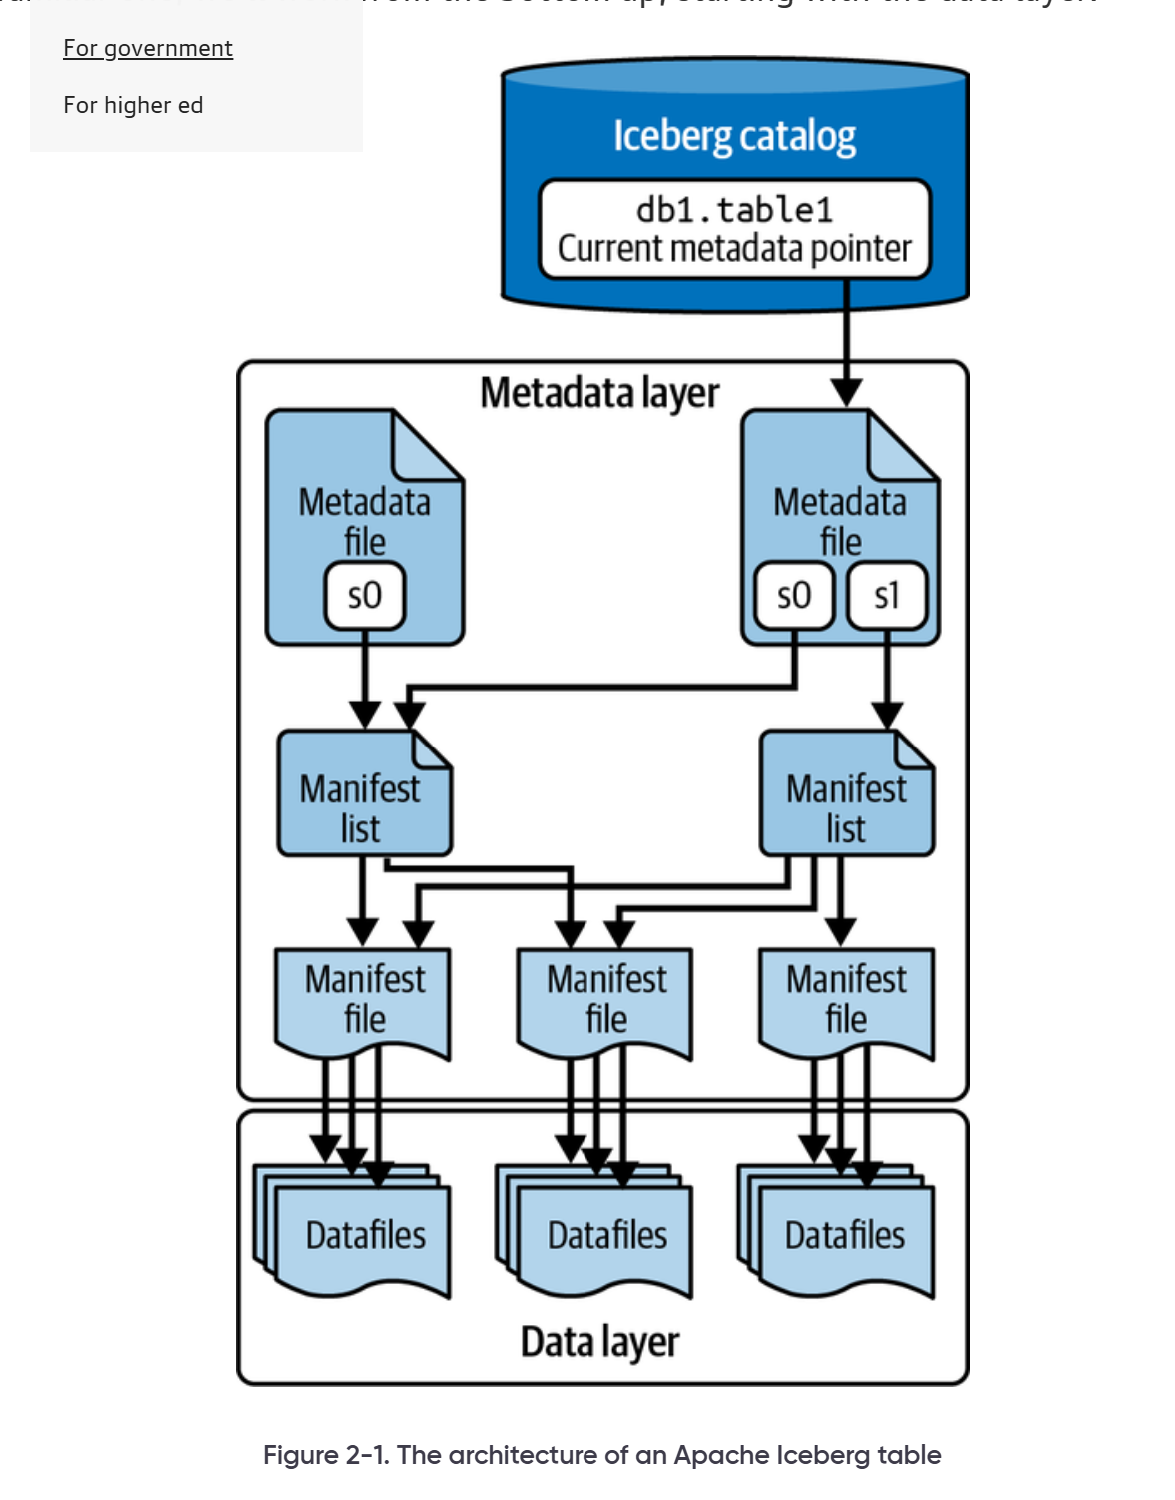

https://www.datacamp.com/tutorial/apache-iceberg -- this is very good read